* * *
<pre> NYU Paris            <i> Artificial intelligence - Fall 2022 </i></pre>
* * *


<h1 align="center"> Lab 2: First steps with scikit-learn </h1>

<pre align="left"> September 8th 2022               <i> Author: Hicham Janati </i></pre>
* * *


##### Goals:
- Get your hands dirty: read and manipulate data as `Numpy` arrays and visualize it using `matplotlib`
- Understand what PCA is and when to use it
- Make your first machine learning prediction with scikit-learn using LDA (linear discriminant analysis)


## 1 - Reading and visualizing data 


First we load a dataset containing handwritten digit images. These are low resolution (8 x 8) images each containing a handwritten digit in (0-9).

In [39]:
import numpy as np
from sklearn.datasets import load_digits
digits = load_digits()
X = digits.data
print("Shape of the data X:", X.shape)
print("First image values reshaped to 8 x 8\n", X[0].reshape(8, 8))
print("Min and Max value in the data:", X.min(), X.max())

Shape of the data X: (1797, 64)
First image values reshaped to 8 x 8
 [[ 0.  0.  5. 13.  9.  1.  0.  0.]
 [ 0.  0. 13. 15. 10. 15.  5.  0.]
 [ 0.  3. 15.  2.  0. 11.  8.  0.]
 [ 0.  4. 12.  0.  0.  8.  8.  0.]
 [ 0.  5.  8.  0.  0.  9.  8.  0.]
 [ 0.  4. 11.  0.  1. 12.  7.  0.]
 [ 0.  2. 14.  5. 10. 12.  0.  0.]
 [ 0.  0.  6. 13. 10.  0.  0.  0.]]
Min and Max value in the data: 0.0 16.0


There are 1797 images with 64 pixels each. The value of each pixel corresponds to a grayscale level between 0 (white) and 16 (black).
Let's visualize the first image. We reshape it to 8 x 8 then display it using `matplotlib`:

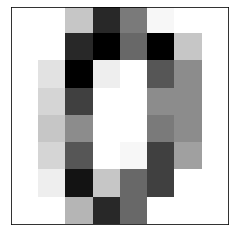

In [40]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(X[0].reshape(8, 8), cmap="Greys")
plt.xticks([])
plt.yticks([])
plt.show()

The "true" digit values (a.k.a the labels or targets) are given in `digits.target`.

In [41]:
y = digits.target
print("Shape of the labels:", y.shape)
print("The first 10 labels:", y[:10])

Shape of the labels: (1797,)
The first 10 labels: [0 1 2 3 4 5 6 7 8 9]


Let's visualize the first 10 images with the true label on top:

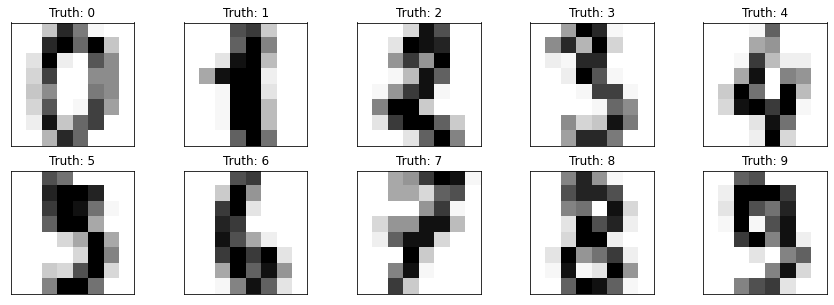

In [42]:
f, axes = plt.subplots(2, 5, figsize=(15, 5))  # 2 rows, 5 columns
for ii, ax in enumerate(axes.flatten()):
    ax.imshow(X[ii].reshape(8, 8), cmap="Greys")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"Truth: {y[ii]}")
plt.show()


## 2 - Dimension reduction: PCA
The data X have 64 dimensions or features. To visualize the entire dataset, we need to transform the data by reducing its dimension to only 2. For the visualization to be truly representative of the data, this dimension reduction should minimize the loss of information. Principal Components Analysis (PCA) constructs a number of "principal components" (features) that capture most of the variance of the data. Let's start with a toy example of two nested spirals we would like to discriminate.

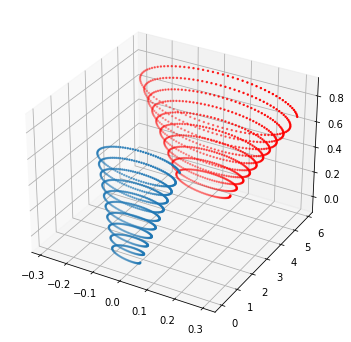

In [43]:
from scipy.spatial.transform import Rotation as R

def make_spiral(n, radius, n_spirals=10):
    angles = np.linspace(0., n_spirals, n) * np.pi * 2 
    x = np.cos(angles) * np.linspace(radius, 3 * radius, n)
    y = np.sin(angles) * np.linspace(radius, 3 * radius, n)
    z = np.linspace(0., 1, n)
    C = np.vstack((x, y, z)).T
    
    r = R.from_matrix([[0.5, 0., 0],
                   [0., 0.6, 0.6],
                   [0, -0.6, 0.6]])
    C = r.apply(C)
    return C

def make_spirals(n, shift=0):
    C1 = make_spiral(n, 0.05)
    C2 = make_spiral(n, 0.1)
    C2[:, 1] += shift
    
    return C1, C2


C1, C2 = make_spirals(1000, shift=5)
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection='3d')
ax.scatter3D(C1.T[0], C1.T[1], C1.T[2], s=2)
ax.scatter3D(C2.T[0], C2.T[1], C2.T[2], s=2, color="r")
plt.show()

One can notice that to discriminate between both spirals, one does not need all 3D coordinates: since the spirals are perfectly nested, a projection on the "base" of the spirals should be enough. PCA can perform such a projection by **linearly** combining the x, y, z variables into two new variables that capture most of the variance.

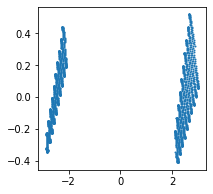

In [44]:
from sklearn.decomposition import PCA

X = np.concatenate((C1, C2))
pca = PCA(2)
pca.fit(X)
X_pca = pca.transform(X)

plt.figure(figsize=(3, 3))
plt.scatter(X_pca.T[0], X_pca.T[1], s=1)
plt.show()

In [45]:
print(X_pca.shape)

(2000, 2)


PCA reduced the dimension of the data from 3 to 2. The scatter plot above shows that both spirals are still clearly separated. It is important to note that **PCA was not provided any information about which spiral is which**: we provided the concatenated coordinates of both spirals. 


 PCA picks new components such that the variance of the projected data is maximized. We can retrieve the percentage of variance of each component:

In [46]:
pca.explained_variance_ratio_

array([0.9904586 , 0.00740871])

The two components account for 75% and 12% the variance of the data. The unexplained variance percentage (lost):

In [47]:
1 - pca.explained_variance_ratio_.sum()

0.0021326882481379483

### Question 1:
 PCA picks new components such that the variance of the projected data is maximized.
 Can you think of a motivation behind this ? How could "preserving information" be associated with "maximizing variance" ?

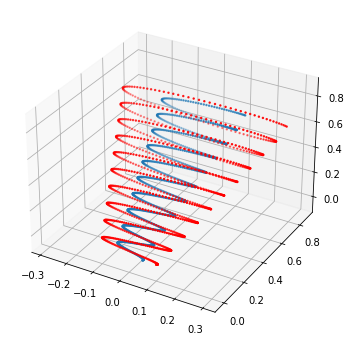

In [48]:
C1, C2 = make_spirals(1000, shift=0)
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection='3d')
ax.scatter3D(C1.T[0], C1.T[1], C1.T[2], s=2)
ax.scatter3D(C2.T[0], C2.T[1], C2.T[2], s=2, color="r")
plt.show()

PCA finds components where the data is spread the most to capture its global patterns. Maximizing spread is maximizing variance. The more a component has variance, the "richer" it is in terms of relevance. Features or components that vary little are not as informative as highly variable ones.


### Question 2:
Before running PCA on these nested spirals, what do you expect to observe in the PCA output ?

The long axis around which the spirals formed must be one of the components. We don't expect the discrimative "above" view since it is not as rich as the lateral one

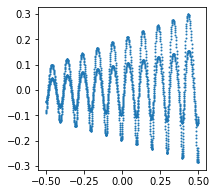

In [49]:
X = np.concatenate((C1, C2))
pca = PCA(3)
pca.fit(X)
X_pca = pca.transform(X)

plt.figure(figsize=(3, 3))
plt.scatter(X_pca.T[0], X_pca.T[1], s=1)
plt.show()

In [50]:
pca.explained_variance_ratio_

array([0.75583307, 0.12392247, 0.12024446])

### Question 3:
Run PCA on the handwritten digits data reducing its dimension from 64 to 2.

In [51]:
import numpy as np
from sklearn.datasets import load_digits
digits = load_digits()
X = digits.data
print("Shape of the data X:", X.shape)
print("First image values reshaped to 8 x 8\n", X[0].reshape(8, 8))
print("Min and Max value in the data:", X.min(), X.max())

X = digits.data
pca = PCA(2)
pca.fit(X)
X_pca = pca.transform(X)


Shape of the data X: (1797, 64)
First image values reshaped to 8 x 8
 [[ 0.  0.  5. 13.  9.  1.  0.  0.]
 [ 0.  0. 13. 15. 10. 15.  5.  0.]
 [ 0.  3. 15.  2.  0. 11.  8.  0.]
 [ 0.  4. 12.  0.  0.  8.  8.  0.]
 [ 0.  5.  8.  0.  0.  9.  8.  0.]
 [ 0.  4. 11.  0.  1. 12.  7.  0.]
 [ 0.  2. 14.  5. 10. 12.  0.  0.]
 [ 0.  0.  6. 13. 10.  0.  0.  0.]]
Min and Max value in the data: 0.0 16.0


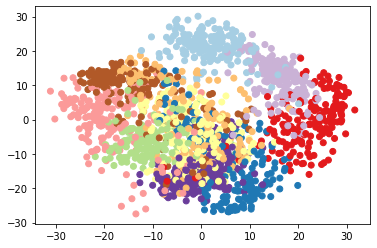

In [52]:
from matplotlib import cm

colors = cm.Paired(np.linspace(0., 1., 10)) # list of 10 colors

colors_all = colors[digits.target]

plt.figure()
plt.scatter(X_pca[:, 0], X_pca[:, 1], color=colors_all)
plt.show()

## 3 - Making your first machine learning prediction 
First we split the data into train and test. Train data are used to _train_ the model i.e to learn using both the images and their true train labels (targets). Test data are used to _test_ the performance of the model by comparing its predictions to the unseen test labels.

We are going to use a linear disciminant analysis classifier (LDA). 

The [sklearn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html) provides short and clear definitions of the model. 

In [53]:
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

X_train, X_test, y_train, y_test = train_test_split(
    X, digits.target, test_size=0.5, shuffle=False
)

lda = LDA()
lda.fit(X_train, y_train)

y_predict = lda.predict(X_test)
y_predict

array([8, 8, 4, 9, 0, 8, 9, 8, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4,
       5, 6, 5, 8, 9, 0, 1, 2, 3, 4, 9, 6, 7, 8, 9, 0, 9, 5, 5, 6, 5, 0,
       9, 8, 9, 8, 4, 1, 7, 7, 3, 9, 1, 2, 5, 8, 2, 0, 1, 2, 6, 3, 3, 5,
       3, 3, 4, 6, 6, 6, 4, 9, 1, 5, 0, 9, 5, 2, 8, 2, 0, 0, 1, 7, 6, 3,
       2, 1, 4, 6, 3, 1, 3, 9, 1, 7, 6, 8, 4, 3, 1, 4, 0, 5, 3, 6, 9, 6,
       1, 7, 5, 4, 4, 7, 2, 8, 2, 2, 9, 7, 9, 5, 4, 4, 9, 0, 8, 9, 8, 0,
       1, 2, 3, 9, 5, 6, 7, 1, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2,
       3, 4, 5, 6, 7, 8, 9, 0, 9, 5, 5, 6, 5, 0, 9, 8, 9, 8, 4, 1, 7, 7,
       3, 5, 1, 0, 0, 7, 8, 2, 0, 1, 2, 6, 3, 3, 7, 3, 3, 4, 6, 6, 6, 9,
       9, 1, 5, 0, 9, 5, 2, 8, 2, 0, 0, 1, 7, 6, 3, 2, 1, 7, 9, 6, 3, 1,
       3, 9, 1, 7, 6, 8, 4, 3, 1, 4, 0, 5, 3, 6, 9, 6, 1, 7, 5, 4, 9, 7,
       2, 8, 2, 2, 5, 7, 9, 5, 4, 7, 8, 4, 9, 0, 8, 9, 8, 0, 1, 2, 3, 4,
       5, 6, 7, 5, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 2, 0, 1, 2, 3, 4, 5, 6,
       7, 8, 9, 0, 9, 5, 5, 6, 5, 0, 9, 8, 9, 5, 4,

### Question 4:
Compute the accuracy of the model by comparing the predictions to the true test labels.

In [54]:
abs(y_predict == y_test).mean()

0.9210233592880979

### Question 5:
Visualize the first 10 test images and their predicted label on top as a title.
**Hint**: re-use the cell above that visualizes 10 images of the data

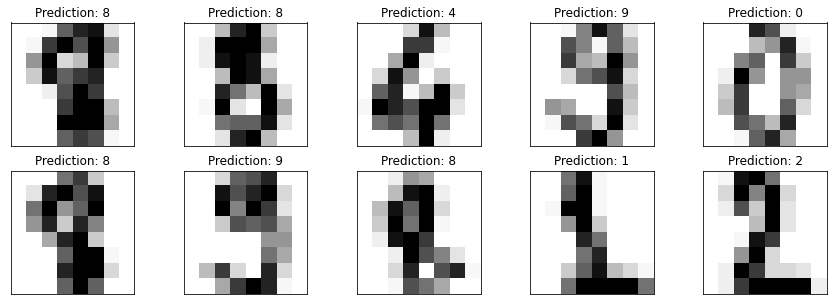

In [55]:

f, axes = plt.subplots(2, 5, figsize=(15, 5))  # 2 rows, 5 columns
for ii, ax in enumerate(axes.flatten()):
    ax.imshow(X_test[ii].reshape(8, 8), cmap="Greys")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"Prediction: {y_predict[ii]}")
plt.show()


### Question 6:
Complet the function below that takes as input the percentage of testing samples and returns the prediction accuracy. Plot the accuracy curve for a list of `test_size`. What do you notice ?

(1779, 64)
(1583, 64)
(1387, 64)
(1192, 64)
(996, 64)
(800, 64)
(604, 64)
(409, 64)
(213, 64)
(17, 64)


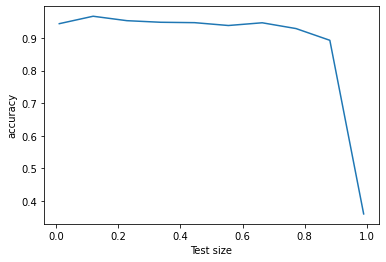

In [56]:
def accuracy(test_size):
    X_train, X_test, y_train, y_test = train_test_split(
    X, digits.target, test_size=test_size, shuffle=True)
    print(X_train.shape)

    lda = LDA()
    lda.fit(X_train, y_train)

    y_predict = lda.predict(X_test)
    
    return abs(y_predict == y_test).mean()


test_sizes = np.linspace(0.01, 0.99, 10)

accuracies = []

for test_size in test_sizes:
    accuracies.append(accuracy(test_size))
    
plt.figure()
plt.plot(test_sizes, accuracies)
plt.xlabel("Test size")
plt.ylabel("accuracy")
plt.show()